Dit is de EDA voor BE.... bestanden, be52.. bestanden.  
Dit bevat verschillende instel waardes voor de linac bij een bepaalde energie. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re


### Overzicht van de data

In [2]:
df_db = pd.read_csv("data/cal_changed.csv", header = None, names=["date", "linac", "file_name", "item", 'part', "value"], )
names_files = list(set(df_db["file_name"]))
df_db.head()

,date,linac,file_name,item,part,value
0,2023-09-13,2325,Be5201,1,4,5201
1,2023-10-04,2325,Be5201,1,4,5201
2,2023-10-11,2325,Be5201,1,4,5201
3,2023-10-18,2325,Be5201,1,4,5201
4,2023-10-25,2325,Be5201,1,4,5201


In [3]:
df_db.shape

(205746, 6)

Deze data bevat de datum van uploaden, nummer van het linac toestel, het bestandsnaam waar de data vandaan komt, item nummer, part nummer en value.  

Het item nummer en part nummer zijn aan elkaar gebonden, en vormen samen een bepaalde instelling op dat apparaat met een bepaalde waarde: value.  

Dit is een deel van de database van maar 1 linac, maar dit bevat al een aardige grootte aan bestanden.  


De bestandsnamen zijn optedelen in 3 categorieën:  

{'Be52', 'Be55', 'Be63'}

{'Mlc_Iso_Centre',  
 'Mlc_Leaf_Sensor_Dir',  
 'Mlc_Leaf_Sensor_Gain',  
 'Mlc_Leaf_Sensor_Off',  
 'Mlc_Leaf_Sensor_Orig',  
 'Mlc_Minr_Off',  
 'Mlc_Sensor_Gains',  
 'Mlc_cal_data',  
 'Mlc_gain_adj',  
 'Mlc_leaf_travel',  
 'Mlc_refl_width'}
  
 {'Optics_Dist_Y1_01_To_40',  
 'Optics_Dist_Y1_41_To_80',  
 'Optics_Dist_Y2_01_To_40',  
 'Optics_Dist_Y2_41_To_80',  
 'Optics_Gen_Cal_Data',  
 'Optics_LP_X_01_To_20',  
 'Optics_LP_X_21_To_40',  
 'Optics_LP_X_41_To_60',  
 'Optics_LP_X_61_To_80',  
 'Optics_LP_Y_01_To_20',  
 'Optics_LP_Y_21_To_40',  
 'Optics_LP_Y_41_To_60',  
 'Optics_LP_Y_61_To_80'}

#### Inzoomen in de data  

Er gaat een focus naar de Be.... bestanden


In [4]:
be52 = [name for name in names_files if "Be52" in name]
be52

['Be5213',
 'Be5206',
 'Be5212',
 'Be5208',
 'Be5219',
 'Be5209',
 'Be5207',
 'Be5215',
 'Be5211',
 'Be5216',
 'Be5205',
 'Be5204',
 'Be5218',
 'Be5201',
 'Be5202',
 'Be5214',
 'Be5217']

Hieruit wordt eerst gekeken naar het eerst soort bestande van deze Be.... bestanden.

In [5]:
be5201 = [row for row in df_db.itertuples() if row.file_name == "Be5201"]
be5201 = pd.DataFrame(be5201)
be5201

,Index,date,linac,file_name,item,part,value
0,0,2023-09-13,2325,Be5201,1,4,5201
1,1,2023-10-04,2325,Be5201,1,4,5201
2,2,2023-10-11,2325,Be5201,1,4,5201
3,3,2023-10-18,2325,Be5201,1,4,5201
4,4,2023-10-25,2325,Be5201,1,4,5201
...,...,...,...,...,...,...,...
5350,5350,2024-02-07,2325,Be5201,1194,128,0
5351,5351,2024-02-14,2325,Be5201,1194,128,0
5352,5352,2024-02-28,2325,Be5201,1194,128,0
5353,5353,2024-04-24,2325,Be5201,1194,128,0


1 bestand bestaat uit: item, part en value waardes. Deze zijn meerendeels vertaald naar woorden. 

linac_items, linac_parts en itemValue_df zijn verbonden met de BE.... bestanden.

agility_parts en mlc_parts zijn verbonden met de andere bestanden.

In [6]:
# loading of the translate tables
linac_items = pd.read_csv("../translate_tbl.csv")
linac_items["Item name"] =  linac_items["Item name"].str.extract(r'i(\d+)').astype("float")
itemValue_df = pd.read_csv("../translate_tbl_item.csv", header = None)
linac_parts = pd.read_csv("../Itemparts.csv")
agility_parts = pd.read_csv("../agility_parts.csv")
mlc_parts = pd.read_csv("../MLC.csv")

# editing the loaded table because it contains 28 smaller tables
table_indices = itemValue_df[itemValue_df[1].str.contains('Table', na=False)].index.tolist()
table_indices.append(len(itemValue_df))
itemValue_dfs = [
    itemValue_df.iloc[table_indices[i] + 1:table_indices[i + 1]]
    for i in range(len(table_indices) - 1)
]

for index in range(len(itemValue_dfs)):
    df = itemValue_dfs[index].dropna(subset=[0])
    df = df.rename(columns=df.iloc[0]).drop(df.index[0]).reset_index(drop=True)
    itemValue_dfs[index] = df


# filling in the gaps in the agility_parts and mlc_parts
def fillinthestrips(df):
    new_rows = []

    for _, row in df.iterrows():
        if "See Item" in str(row['Description']):
            # Extract the referenced item number
            ref_item = int(row['Description'].split("Item ")[1].split(" ")[0])
            # Get all parts of the referenced item
            ref_parts = df[df['Item'] == ref_item].copy()
            # Update item number and collect rows
            ref_parts['Item'] = row['Item']
            new_rows.extend(ref_parts.to_dict('records'))
        else:
            new_rows.append(row.to_dict())

    # Create the new DataFrame
    return pd.DataFrame(new_rows).reset_index(drop=True)
    
mlc_parts = fillinthestrips(mlc_parts)
agility_parts = fillinthestrips(agility_parts)

# combining the 2 tables
unique_df = pd.concat([mlc_parts, agility_parts]).drop_duplicates(
    subset=['Item', 'Part'], 
    keep='first'
).reset_index(drop=True)

unique_df["Part"] = unique_df["Part"].astype(int)

part_value_tr = {1: 2, 2 :7, 3: 8,4 : 9, 5 : 32, 6 : 39, 7 : 40, 8 : 41, 9 : 42, 10 : 182, 11 : 199, 
                 12 : 200, 13 : 201, 14 : 202, 15 : 203, 16 : 245, 17 : 268, 18 : 318, 19 : 319, 
                 20 : 382, 21 : 383, 22 : 408, 23 : 409, 24 : 410, 25 : 416, 26 : 418, 27 : 433,
                 28 : 494, 29 : 553, 30 : 685, 31 : 686, 32 : 650}

De vertaal tabbelen zijn nu compleet en kunnen worden gebruikt.

In [7]:
description = {}

for row in be5201.itertuples():
    item = linac_items[linac_items["Item name"] == row.item]
    part = linac_parts[linac_parts["Part No."] == row.part]
    if not item.empty and not part.empty:
        description[str(item.iloc[0,2])] = f"item: {row.item}, part: {row.part}, {str(part.iloc[0,2])}"

Kijken naar de values van Be5201 bestanden over de tijd. Hoeveel aanpassing zijn er aanwezig geweest per item & part combinatie.

In [8]:

# part en items, alle values verzamelen van de verschillende data

scattering = {}
dates = list(set(be5201["date"]))
for row in be5201[be5201["date"] == dates[0]][["item", "part"]].itertuples():
    if row.item != 1194:
        allvalues = [row_part.value for row_part in be5201.itertuples() if [row.item, row.part] == [row_part.item, row_part.part]]
        scattering[row] = allvalues


In [9]:
# verschil berekenen van alle verschillende data

for item in scattering:
    allvalues = scattering[item]
    newvalues = [allvalues[index] - allvalues[index + 1] for index in range(len(allvalues)-1)]
    scattering[item] = newvalues

In [10]:
# hoeveelheid veranderingen
changes = {}
for item in scattering:
    allvalues = scattering[item]
    amount = [1 for value in allvalues if value != 0]
    if sum(amount) != 0:
        changes[item] = sum(amount)

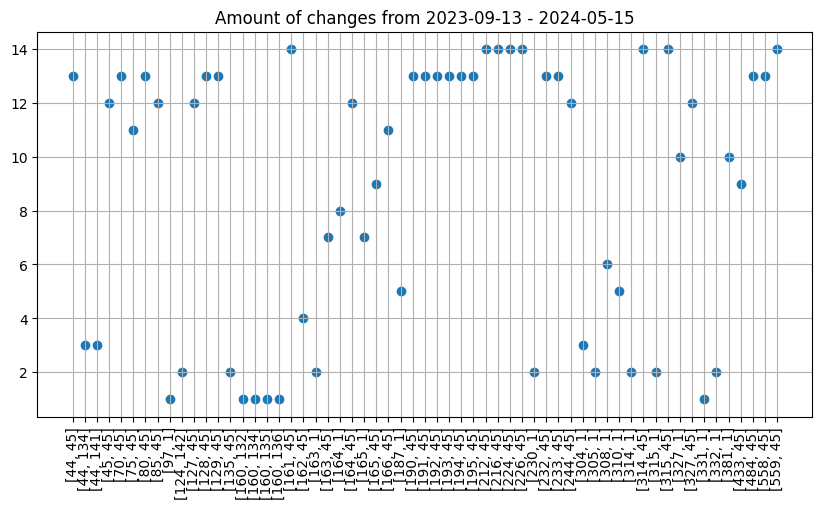

In [11]:
labels = [str(list(item)[1:]) for item in changes.keys()]
plt.figure(figsize=(10, 5))
plt.scatter(y = changes.values(), x = labels)
plt.xticks(rotation=90)
plt.title(f"Amount of changes from {min(dates)} - {max(dates)}")
plt.grid()
plt.show()


Kijkende naar alle be52 bestanden

In [12]:
df_be52 = [row for row in df_db.itertuples() if row.file_name in be52]
df_be52 = pd.DataFrame(df_be52)

In [13]:
# change df
df_pivot = df_be52.pivot(index=["linac", "file_name", "item", "part"], columns="date", values="value")
df_pivot.reset_index(inplace=True)

# the dates all the different file types been uploaded
file_dates = {name : sorted(list(set(df_be52[df_be52["file_name"] == name]["date"]))) for name in set(df_be52["file_name"])}

In [14]:
#how much every part&item changed
changes_per_file = {}

for file_name, file_date in file_dates.items():
    # grab the dates that this file has been uploaded
    df_change = df_pivot[df_pivot["file_name"] == file_name].loc[:,file_date]
    # Calculate how much difference there is between old and new
    df_changes =  df_change.iloc[:,1:].values - df_change.iloc[:,:-1].values
   
    # make a df from the changes and the information of linac, item en part
    df_changed = pd.concat([df_pivot[df_pivot["file_name"] == file_name].loc[:,["linac", "item", "part"]].reset_index(), 
               pd.DataFrame(df_changes, columns=df_change.columns[1:])], axis=1)
    df_changed[f"first_entry: {file_date[0]}"] = df_pivot.loc[:,file_date[0]]
    changes_per_file[file_name] = df_changed



In [15]:
#get the sum of the amount of changes

plotting_per_file = pd.DataFrame()
for file_name, df_changes in changes_per_file.items():
    for linac in set(df_changes["linac"]):
        # get how many times there was a diffence between col
        date_columns = df_changes.columns.difference(['date', 'linac', 'file_name', 'item', 'part', df_changes.columns[-1]])
        plotting = list((df_changes[date_columns] != 0).sum()[:-1]) 
        first_date = re.findall(r"\d{4}-\d{2}-\d{2}", df_changes.columns[-1])[0]
        # # set it in the dict
        data = {
            "Amount": plotting,
            "Date": list(date_columns[:-1]),
            "Linac": [linac] * len(plotting),
            "File name": [file_name] * len(plotting),
            "First entry": [first_date] * len(plotting)
        }
        plotting_per = pd.DataFrame(data) 
        plotting_per_file = pd.concat([plotting_per_file, plotting_per])


In [16]:
px.line(plotting_per_file, x='Date', y='Amount', color='File name', markers=True, symbol='Linac', hover_data="First entry")


In [17]:
total_df = pd.DataFrame()
for filename, df_changes in changes_per_file.items():
    if df_changes.columns[-2] != "part":

        old_data = df_changes[df_changes.columns[-1]]
        dif = df_changes[df_changes.columns[-2]]

        data = {
                "File name": [file_name] * len(df_changes),
                "Item & part": "I:"+ df_changes["item"].astype(str) + " P:"+ df_changes["part"].astype(str),
                "Difference": list(dif),
                "Old data": list(old_data),
                "New data": list(old_data - dif)
            }
        temp_df = pd.DataFrame(data) 
        total_df = pd.concat([total_df, temp_df])


In [18]:
total_df = pd.DataFrame()
ip = "I:1 P:4"
for filename, df_changes in changes_per_file.items():
    if df_changes.columns[-2] != "part":
        df_changes["Item & part"] = "I:"+ df_changes["item"].astype(str) + " P:"+ df_changes["part"].astype(str)
        dates = list(df_changes.columns)[4:-2]
        data = {
                "Linac": [df_changes["linac"][1]] * len(dates),
                "Item & part": [ip] * len(dates),
                "date": dates,
                "Difference": df_changes[df_changes["Item & part"] == ip][dates].values[0],
                "First entry": df_changes[df_changes["Item & part"] == ip].iloc[:,-2].values[0]
            }
        
        temp_df = pd.DataFrame(data) 
        total_df = pd.concat([total_df, temp_df])

De Be.... bestanden Item & parts bevat  
    gun current

In [19]:
for key, value in description.items():
    if "gun" in key:
        print(f"{value} : {key}")

item: 123, part: 133, Parameter 3 function : This item shows the servo error from the slits gun control system. The item is not used in digital accelerators fitted with a slitless flight tube and hardware gun servo.
item: 186, part: 1, Setting value : This item controls the loop gain of the hardware system. It is configured for the hardware gun servo option only.
item: 187, part: 1, Setting value : This item controls an analog reference voltage used by the hardware gun servo option.
item: 216, part: 45, Confirmed value : The value of this item is the monitored voltage of the electron gun.
item: 235, part: 45, Confirmed value : This item is not used when the digital accelerator is fitted with a slitless flight tube and hardware gun servo.
item: 327, part: 200, Process_Param_24_Part  : The servo control item for the electron gun filament current.
item: 369, part: 1, Setting value : This item controls the gun aim level for servo operation. The item is not used when the digital accelerator

In [20]:
be5201["Part&item"] = "I:"+ be5201["item"].astype(str) + " P:"+ be5201["part"].astype(str)
be5201[be5201["Part&item"] == "I:381 P:1"]

px.line(be5201[be5201["Part&item"] == "I:381 P:1"], x="date", y ="value" )


In [55]:

col = be5201[be5201["date"] == "2024-05-15"]["value"].values - be5201[be5201["date"] == "2023-09-13"]["value"].values
temp_df = be5201[be5201["date"] == "2024-05-15"]
temp_df["dif"] = col

pI = temp_df[temp_df["dif"] != 0]["Part&item"]


C:\Users\Laris\AppData\Local\Temp\ipykernel_20188\2290091072.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
plotting = be5201[be5201["Part&item"].isin(pI)]

fig = px.line(plotting, x="date", y ="value" ,color="Part&item", title = f"Alle aangepaste items in 1 plot met de waarde van aanpassing")
fig.show()


Een mogelijke verdeling van deze part en itmes is te doen op basis van de onderdelen in de tekeningen van de machine vanuit elekta.

In [ ]:
groups = pd.read_csv("data/groups_partly.tsv", sep="\t")
groups["Part&item"] = "I:"+ groups["item"].astype(str) + " P:"+ groups["part"].astype(str)

plotting = pd.merge(groups, be5201, on="Part&item", how="inner")

fig = px.line(plotting, x="date", y ="value" ,color="groep", title = f"meukjes")

,groep,item_x,part_x,Part&item,Index,date,linac,file_name,item_y,part_y,...,Item name,Unnamed: 1,Description,Data type,Range,Resolution,Units,Service page(s),System(s),See
0,dosismetry system pressure/temp,559,45,I:559 P:45,3390,2023-09-13,2325,Be5201,559,45,...,559.0,Pressure 2,Part of the dual dose monitoring system. The i...,Not available,0 to 1300,Integer,mBar (absolute),Dose Calibration,Dosimetry [Ref: 9],Not available
1,dosismetry system pressure/temp,559,45,I:559 P:45,3391,2023-10-04,2325,Be5201,559,45,...,559.0,Pressure 2,Part of the dual dose monitoring system. The i...,Not available,0 to 1300,Integer,mBar (absolute),Dose Calibration,Dosimetry [Ref: 9],Not available
2,dosismetry system pressure/temp,559,45,I:559 P:45,3392,2023-10-11,2325,Be5201,559,45,...,559.0,Pressure 2,Part of the dual dose monitoring system. The i...,Not available,0 to 1300,Integer,mBar (absolute),Dose Calibration,Dosimetry [Ref: 9],Not available
3,dosismetry system pressure/temp,559,45,I:559 P:45,3393,2023-10-18,2325,Be5201,559,45,...,559.0,Pressure 2,Part of the dual dose monitoring system. The i...,Not available,0 to 1300,Integer,mBar (absolute),Dose Calibration,Dosimetry [Ref: 9],Not available
4,dosismetry system pressure/temp,559,45,I:559 P:45,3394,2023-10-25,2325,Be5201,559,45,...,559.0,Pressure 2,Part of the dual dose monitoring system. The i...,Not available,0 to 1300,Integer,mBar (absolute),Dose Calibration,Dosimetry [Ref: 9],Not available
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,gantry rotation system,44,134,I:44 P:134,85,2024-02-07,2325,Be5201,44,134,...,44.0,D/rate 1,This item specifies the nominal dose rate to b...,Integer,0 MU/min to 1200 MU/min,1 MU/min,MU/min,"AFC, Beam Control, Dose Calibration, LV PSU, S...",Power Supplies and Interlocks [Ref: 5],Ref 14: 4513 330 7047 - sheet 1
731,gantry rotation system,44,134,I:44 P:134,86,2024-02-14,2325,Be5201,44,134,...,44.0,D/rate 1,This item specifies the nominal dose rate to b...,Integer,0 MU/min to 1200 MU/min,1 MU/min,MU/min,"AFC, Beam Control, Dose Calibration, LV PSU, S...",Power Supplies and Interlocks [Ref: 5],Ref 14: 4513 330 7047 - sheet 1
732,gantry rotation system,44,134,I:44 P:134,87,2024-02-28,2325,Be5201,44,134,...,44.0,D/rate 1,This item specifies the nominal dose rate to b...,Integer,0 MU/min to 1200 MU/min,1 MU/min,MU/min,"AFC, Beam Control, Dose Calibration, LV PSU, S...",Power Supplies and Interlocks [Ref: 5],Ref 14: 4513 330 7047 - sheet 1
733,gantry rotation system,44,134,I:44 P:134,88,2024-04-24,2325,Be5201,44,134,...,44.0,D/rate 1,This item specifies the nominal dose rate to b...,Integer,0 MU/min to 1200 MU/min,1 MU/min,MU/min,"AFC, Beam Control, Dose Calibration, LV PSU, S...",Power Supplies and Interlocks [Ref: 5],Ref 14: 4513 330 7047 - sheet 1


In [56]:
for pi in pI:
    be5201[be5201["Part&item"] == pi]
    item = re.findall(r"(?>I:)(\d+)", pi)[0]
    
    name = linac_items[linac_items["Item name"] == int(item)]["Description"]

    fig = px.line(be5201[be5201["Part&item"] == pi], x="date", y ="value" , title = f"{pi}")
    print(f"item {item}: {name.values[0]}")
    fig.show()


item 44: This item specifies the nominal dose rate to be used for the current segment by dose channel 1. It is exactly equivalent to writing to the nominal dose rate. The displayed value shows the actual dose rate being produced by the linear accelerator.


item 44: This item specifies the nominal dose rate to be used for the current segment by dose channel 1. It is exactly equivalent to writing to the nominal dose rate. The displayed value shows the actual dose rate being produced by the linear accelerator.


item 44: This item specifies the nominal dose rate to be used for the current segment by dose channel 1. It is exactly equivalent to writing to the nominal dose rate. The displayed value shows the actual dose rate being produced by the linear accelerator.


item 45: The displayed value of this item shows the actual dose rate being produced by the linear accelerator for dose channel 2.


item 70: The prescribed or keyboard-entered value of this item may be applied using ASU to cause assisted setup of the gantry.


item 75: The prescribed or keyboard-entered value of this item may be applied using ASU to cause assisted setup of the beam limited device angle.  The displayed Actual value shows the actual head angle.


item 80: The prescribed or keyboard-entered value of this item can be applied by using ASU to cause assisted setup of the X1 diaphragm.


item 85: The prescribed or keyboard-entered value of this item is used during a movement segment to determine the required START position of the X2 diaphragm.


item 97: This item allows the magnetron tuner rest position to be set for each energy and stored in the calibration block.


item 127: This item shows the servo error from the 2R plates centring system.


item 128: This item shows the servo error from the 2T plates centring system.


item 129: This item shows the servo error from the RF phase error detector.


item 160: This item monitors the relative readings of a number of signals from the ion chamber plates. During the set up procedure, each reading is normalized against the first channel.


item 160: This item monitors the relative readings of a number of signals from the ion chamber plates. During the set up procedure, each reading is normalized against the first channel.


item 160: This item monitors the relative readings of a number of signals from the ion chamber plates. During the set up procedure, each reading is normalized against the first channel.


item 160: This item monitors the relative readings of a number of signals from the ion chamber plates. During the set up procedure, each reading is normalized against the first channel.


item 161: The magnetron tuner servo control item.


item 163: The low power phase shifter servo control item.


item 163: The low power phase shifter servo control item.


item 164: The 2R servo control item controls the current required to make the beam symmetrical.


item 164: The 2R servo control item controls the current required to make the beam symmetrical.


item 165: The 2T servo control item controls the current required to make the beam symmetrical.


item 165: The 2T servo control item controls the current required to make the beam symmetrical.


item 187: This item controls an analog reference voltage used by the hardware gun servo option.


item 190: The monitor item of the inner plate of the ion chamber.


item 191: The monitor item of the outer plate of the ion chamber.


item 192: The monitor item of the 2TB plate.


item 193: The monitor item of the 2TA plate.


item 194: The monitor item of the 2RG plate.


item 195: The monitor item of the 2RT plate.


item 212: The value of this item is the monitored voltage across the magnetron filament.


item 216: The value of this item is the monitored voltage of the electron gun.


item 224: This item monitors ion chamber temperature probe 1, if fitted as part of the dose compensation option.


item 226: This item monitors ion chamber temperature probe 2, if fitted as part of the dose compensation option. The item is part of the dual temperature monitoring system.


item 230: This item sets the position of the low power phase shifter of the AFC system.


item 232: This item is the signal from phase leg 1 of the AFC system.


item 233: This item is the signal from phase leg 2 of the AFC system.


item 244: The value of this item is the HT current used by the magnetron filament rundown.


item 304: This is the servo control item for the coarse (main) bending magnet current. It shows the readback value from LV PSU control PCB 13C in the low voltage PSU assembly (Area 13).


item 305: This is the servo control item for the fine (top-up) bending magnet current. It shows the readback value from LV PSU control PCB 13G in the low voltage PSU assembly (Area 13).


item 308: Sets the balance gain for the 2R coil.


item 310: Sets the balance gain for the 2T coil.


item 314: nan


item 314: nan


item 315: This item sets the calibration of dosimetry channel 2. Increase the value of this item to increase the dose rate reading. (See i314 for more details.)


item 315: This item sets the calibration of dosimetry channel 2. Increase the value of this item to increase the dose rate reading. (See i314 for more details.)


item 327: The servo control item for the electron gun filament current.


item 327: The servo control item for the electron gun filament current.


item 331: The control item for the 1T centring coil.


item 332: The control item for the 1R centring coil.


item 381: This item controls the electron gun aim current level for servo operation.


item 484: This item shows the sum of the outputs of all the dose plates of the ion chamber.


item 558: Part of the dual dose monitoring system. The item monitors dosimetry pressure sensor 1, which is fitted and configured as part of the dose compensation option only.


item 559: Part of the dual dose monitoring system. The item monitors dosimetry pressure sensor 2, which is fitted and configured as part of the dose compensation option only.
